DistilBERT is a smaller, faster, and lighter version of BERT (Bidirectional Encoder Representations from Transformers), an encoder-based transformer model introduced by Google in 2018. DistilBERT retains most of BERT's performance while being significantly more efficient, making it a practical choice for many natural language processing (NLP) tasks, including sentiment analysis.

Our goal is to classify each review into positive or negative sentiment categories by leveraging DistilBERT's capabilities. This involves loading the pre-trained DistilBERT model, preparing the dataset, and fine-tuning the model to our specific task.

KNOWLEDGE DISTILLATION

Model distillation is a technique used to compress the knowledge of a large, complex model (often referred to as the "teacher") into a smaller, more efficient model (known as the "student"). This process involves training the student model to replicate the behavior of the teacher model. The key advantage of model distillation is that it enables the student model to achieve high performance levels, comparable to the teacher model, but with significantly reduced computational resources and faster inference times. DistilBERT is a product of this distillation process, derived from BERT, where it captures the essence of what BERT learns but in a more compact and efficient form.



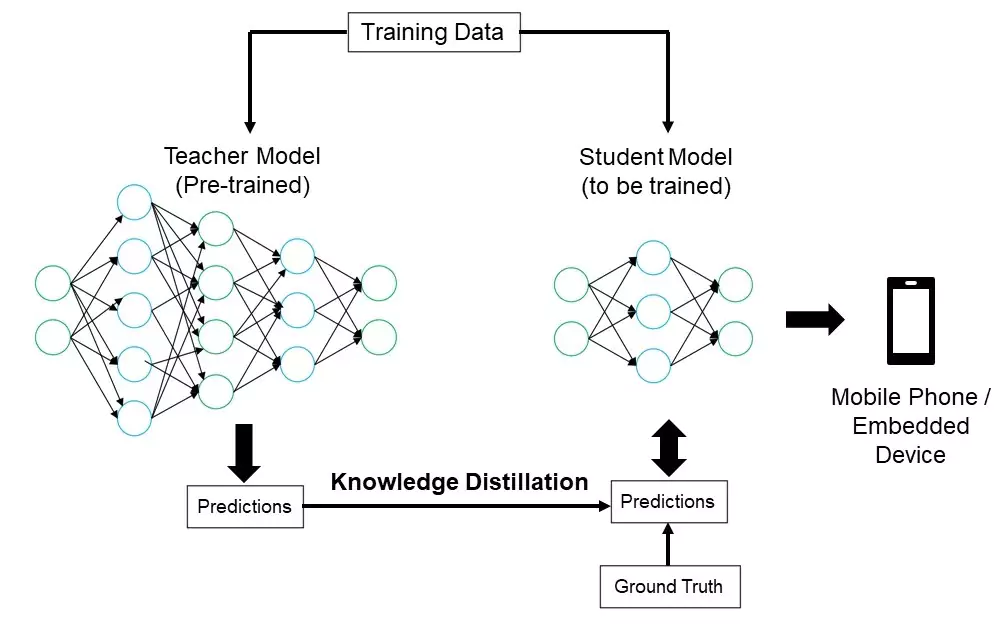

In [1]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import DistilBertModel, DistilBertTokenizerFast
from torch.utils.data import DataLoader
from torch.optim import AdamW

In [2]:
!wget https://raw.githubusercontent.com/kyuz0/llm-chronicles/main/datasets/restaurant_reviews.csv

--2025-06-12 16:03:15--  https://raw.githubusercontent.com/kyuz0/llm-chronicles/main/datasets/restaurant_reviews.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2861025 (2.7M) [text/plain]
Saving to: ‘restaurant_reviews.csv’

restaurant_reviews. 100%[===================>]   2.73M  --.-KB/s    in 0.04s   

2025-06-12 16:03:16 (64.9 MB/s) - ‘restaurant_reviews.csv’ saved [2861025/2861025]



In [3]:
df = pd.read_csv('restaurant_reviews.csv')
display(df.head())

,Review,Rating
0,The ambience was good food was quite good . ha...,positive
1,Ambience is too good for a pleasant evening. S...,positive
2,A must try.. great food great ambience. Thnx f...,positive
3,Soumen das and Arun was a great guy. Only beca...,positive
4,Food is good.we ordered Kodi drumsticks and ba...,positive


In [4]:
# Map sentiments to numerical labels
sentiment_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
df['Rating'] = df['Rating'].map(sentiment_mapping)

In [5]:
df.head()# Display statistics about the dataset
print("\nDataset Statistics:")
print(df['Rating'].value_counts())


Dataset Statistics:
Rating
2    6331
0    2428
1    1192
Name: count, dtype: int64


In [6]:
class ReviewDataset(Dataset):
    def __init__(self, csv_file, tokenizer, max_length):
        self.dataset = pd.read_csv(csv_file)
        self.tokenizer = tokenizer
        self.max_length = max_length
        # Map sentiments to numerical labels
        self.label_dict = {'negative': 0, 'neutral': 1, 'positive': 2}

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        review_text = self.dataset.iloc[idx, 0]  # Assuming reviewText is the first column
        sentiment = self.dataset.iloc[idx, 1]  # Assuming sentiment is the second column
        labels = self.label_dict[sentiment]  # Convert sentiment to numerical label

        # Tokenize the review text
        encoding = self.tokenizer.encode_plus(
          review_text,
          add_special_tokens=True,  # Add [CLS] token at the start for classification
          max_length=self.max_length,
          return_token_type_ids=False,
          padding='max_length',
          return_attention_mask=True,
          return_tensors='pt',
          truncation=True
        )

        return {
          'review_text': review_text,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(), # this is NOT self-attention!
          'labels': torch.tensor(labels, dtype=torch.long)
        }

In [7]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
review_dataset = ReviewDataset('restaurant_reviews.csv', tokenizer, 512)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [8]:
review_dataset[0]

{'review_text': 'The ambience was good food was quite good . had Saturday lunch which was cost effective . Good place for a sate brunch. One can also chill with friends and or parents. Waiter Soumen Das was really courteous and helpful.',
 'input_ids': tensor([  101,  1996,  2572, 11283,  5897,  2001,  2204,  2833,  2001,  3243,
          2204,  1012,  2018,  5095,  6265,  2029,  2001,  3465,  4621,  1012,
          2204,  2173,  2005,  1037,  2938,  2063,  7987,  4609,  2818,  1012,
          2028,  2064,  2036, 10720,  2007,  2814,  1998,  2030,  3008,  1012,
         15610,  2061, 27417,  8695,  2001,  2428,  2457, 14769,  1998, 14044,
          1012,   102,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0, 

In [9]:
tokenizer.decode(review_dataset[0]['input_ids'])

'[CLS] the ambience was good food was quite good. had saturday lunch which was cost effective. good place for a sate brunch. one can also chill with friends and or parents. waiter soumen das was really courteous and helpful. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [

In [10]:
from torch.utils.data import DataLoader, random_split

# Split dataset into training and validation
train_size = int(0.8 * len(df))
val_size = len(df) - train_size
train_dataset, test_dataset = random_split(review_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

In [11]:
# Show number of batches
len(train_loader), len(test_loader)

(498, 125)

Fine-tuning with custom classfier layer

In [12]:
class CustomDistilBertForSequenceClassification(nn.Module):
    def __init__(self, num_labels=3):
        super(CustomDistilBertForSequenceClassification, self).__init__()
        self.distilbert = DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.pre_classifier = nn.Linear(768, 768)  # DistilBERT's hidden size is 768
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(768, num_labels)

    def forward(self, input_ids, attention_mask):
        distilbert_output = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = distilbert_output[0]  # (batch_size, sequence_length, hidden_size)
        pooled_output = hidden_state[:, 0]  # we take the representation of the [CLS] token (first token)
        pooled_output = self.pre_classifier(pooled_output)
        pooled_output = nn.ReLU()(pooled_output)
        pooled_output = self.dropout(pooled_output) # regularization
        logits = self.classifier(pooled_output)
        return logits

In [13]:
model = CustomDistilBertForSequenceClassification()

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [14]:
# Inspect DistilBERT
print(model.distilbert)

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): DistilBertSdpaAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): L

Fine-tuning DistilBERT involves training the model on our specific dataset to adjust all of its weights, including those in the transformer layers and not just the final classifier layer. This comprehensive update allows the model to better adapt to the nuances of our sentiment analysis task. We use the AdamW optimizer for efficient weight adjustments and train over several epochs, monitoring loss to gauge progress. This method ensures that the model becomes finely tuned to our specific classification challenge, leveraging the full power of DistilBERT's pre-trained knowledge and making it more effective for our dataset.

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

optimizer = AdamW(model.parameters(), lr=5e-5)

model.train()
for epoch in range(10):
    for i, batch in enumerate(train_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        logits = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = nn.CrossEntropyLoss()(logits, labels)
        loss.backward()
        optimizer.step()

        if (i + 1) % 100 == 0:
            print(f"Epoch {epoch + 1}, Batch {i + 1}, Loss: {loss.item():.4f}")

Epoch 1, Batch 100, Loss: 0.2835
Epoch 1, Batch 200, Loss: 0.2512
Epoch 1, Batch 300, Loss: 0.1734
Epoch 1, Batch 400, Loss: 0.5238
Epoch 2, Batch 100, Loss: 0.2402
Epoch 2, Batch 200, Loss: 0.3105
Epoch 2, Batch 300, Loss: 0.2397
Epoch 2, Batch 400, Loss: 0.3637
Epoch 3, Batch 100, Loss: 0.7123
Epoch 3, Batch 200, Loss: 0.4274
Epoch 3, Batch 300, Loss: 0.3150
Epoch 3, Batch 400, Loss: 0.0999
Epoch 4, Batch 100, Loss: 0.0793
Epoch 4, Batch 200, Loss: 0.0847
Epoch 4, Batch 300, Loss: 0.0206
Epoch 4, Batch 400, Loss: 0.0253
Epoch 5, Batch 100, Loss: 0.1822
Epoch 5, Batch 200, Loss: 0.2052
Epoch 5, Batch 300, Loss: 0.0259
Epoch 5, Batch 400, Loss: 0.1885
Epoch 6, Batch 100, Loss: 0.0115
Epoch 6, Batch 200, Loss: 0.0057
Epoch 6, Batch 300, Loss: 0.2151
Epoch 6, Batch 400, Loss: 0.0150
Epoch 7, Batch 100, Loss: 0.0054
Epoch 7, Batch 200, Loss: 0.0105
Epoch 7, Batch 300, Loss: 0.0506
Epoch 7, Batch 400, Loss: 0.0060
Epoch 8, Batch 100, Loss: 0.0104
Epoch 8, Batch 200, Loss: 0.0352
Epoch 8, B

In [16]:
model.eval()
total_correct = 0
total = 0
for batch in test_loader:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels'].to(device)

    with torch.inference_mode():
        logits = model(input_ids=input_ids, attention_mask=attention_mask)
    predictions = torch.argmax(logits, dim=1)
    total_correct += (predictions == labels).sum().item()
    total += predictions.size(0)

print(f'Test Accuracy: {total_correct / total:.4f}')

Test Accuracy: 0.8488


In [17]:
def predict_sentiment(review_text, model, tokenizer, max_length = 512):
    """
    Predicts the sentiment of a given review text.

    Args:
    - review_text (str): The review text to analyze.
    - model (torch.nn.Module): The fine-tuned sentiment analysis model.
    - tokenizer (PreTrainedTokenizer): The tokenizer for encoding the text.
    - max_length (int): The maximum sequence length for the model.

    Returns:
    - sentiment (str): The predicted sentiment label ('negative', 'neutral', 'positive').
    """

    # Ensure the model is in evaluation mode
    model.eval()

    # Tokenize the input text
    encoding = tokenizer.encode_plus(
          review_text,
          add_special_tokens=True,
          max_length=max_length,
          return_token_type_ids=False,
          padding='max_length',
          return_attention_mask=True,
          return_tensors='pt',
          truncation=True
    )

    input_ids = encoding['input_ids']
    attention_mask = encoding['attention_mask']

    # Move tensors to the same device as the model
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)

    with torch.inference_mode():
        # Forward pass, get logits
        logits = model(input_ids=input_ids, attention_mask=attention_mask)

    # Extract the highest scoring output
    prediction = torch.argmax(logits, dim=1).item()

    # Map prediction to label
    label_dict = {0: 'negative', 1: 'neutral', 2: 'positive'}
    sentiment = label_dict[prediction]

    return sentiment

In [18]:
# Test
review_1 = "We ordered from Papa Johns a so-called pizza... what to say? I'd rather eat a piece of dry cardboard, calling this pizza is an insult to Italians! "
review_2 = "I guess PizzaHut is decent but far from the Italian pizza. This is not going to blow you away, but still quite ok in the end."
review_3 = "Gino's pizza is what authentical Neapolian pizza tastes like, highly recommended."

print(predict_sentiment(review_1, model, tokenizer))
print(predict_sentiment(review_2, model, tokenizer))
print(predict_sentiment(review_3, model, tokenizer))

negative
neutral
positive
